## Imports

In [53]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
import warnings
warnings.simplefilter("ignore")

## Reading Data, Cleaning Data, and Exploratory Data Analysis

In [54]:
data = pd.read_csv("data/raw/healthcare-dataset-stroke-data.csv")

In [55]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [56]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [57]:
print(data.shape)

(5110, 12)


In [58]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [59]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [61]:
data['age'] = data['age'].astype('int64')
data.drop('id', axis=1, inplace=True)
data['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [62]:
data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

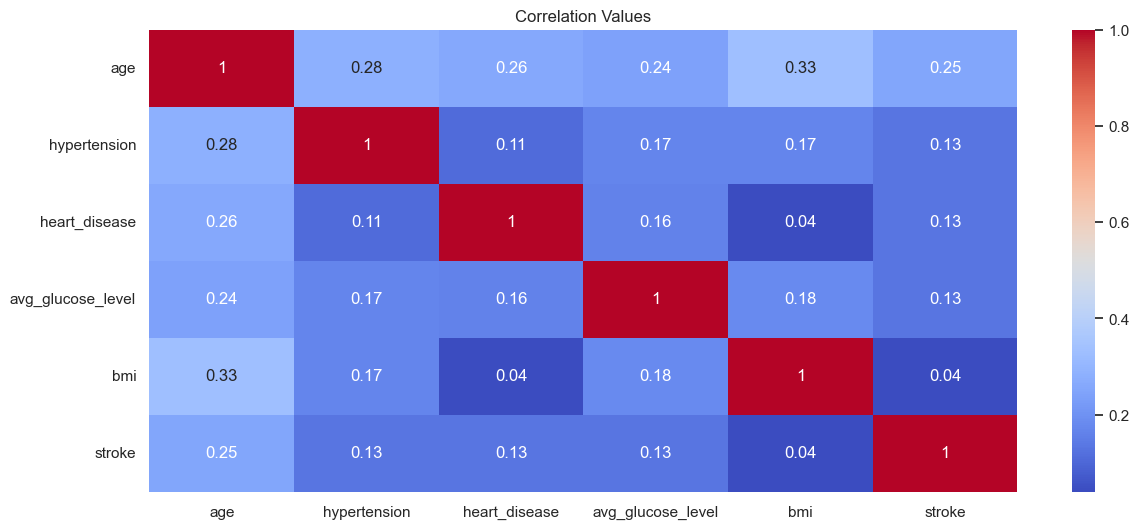

In [63]:
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(numeric_only=True).round(2), annot=True, cmap='coolwarm')
plt.title('Correlation Values')
plt.show()

Due to the presence of some null values in the bmi column within the dataset, I will impute the missing values in order to retain important data for the model

In [64]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=42)
data['bmi'] = imp.fit_transform(data['bmi'].values.reshape(-1, 1))

In [65]:
data['bmi'].isna().sum()

0

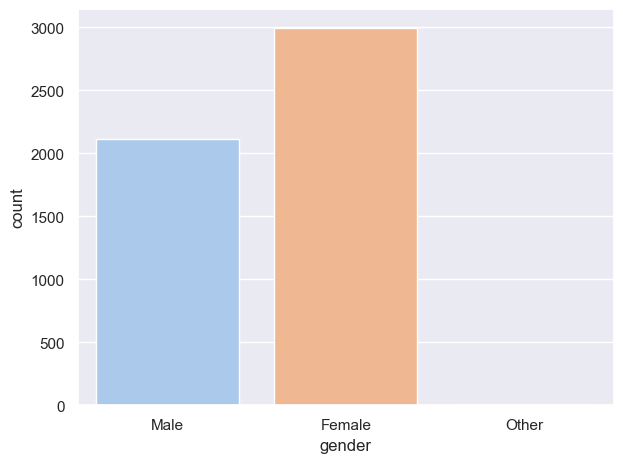

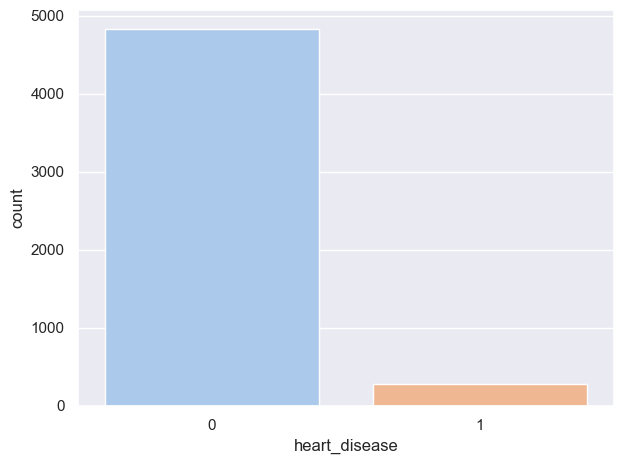

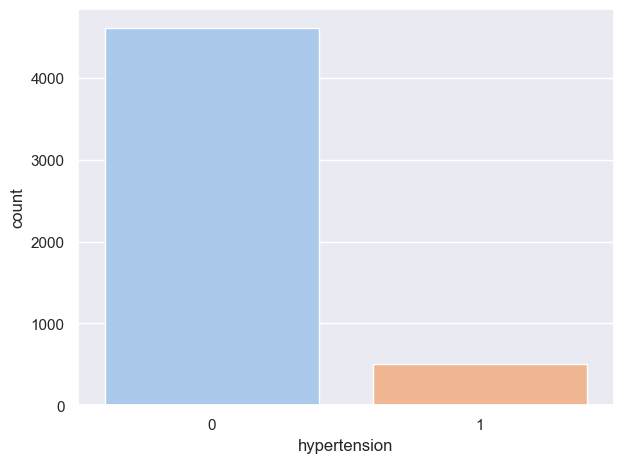

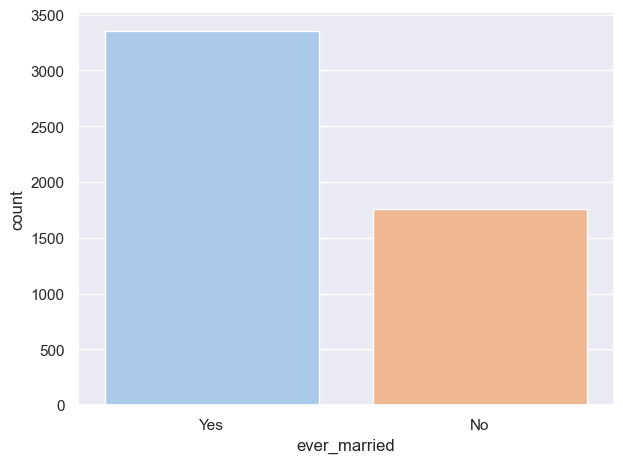

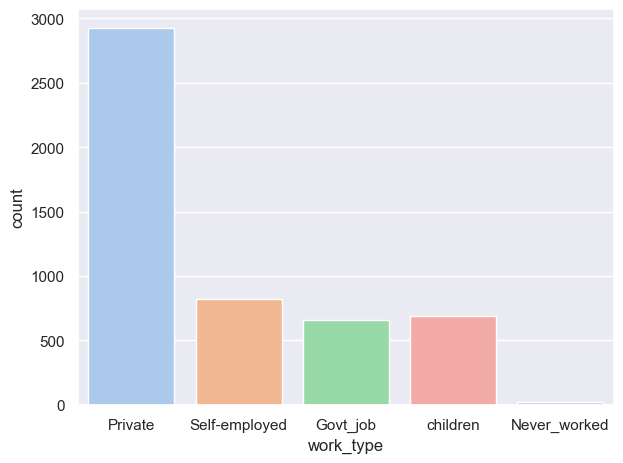

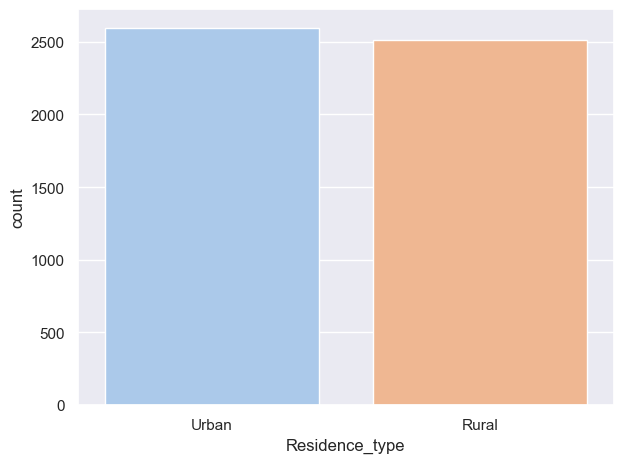

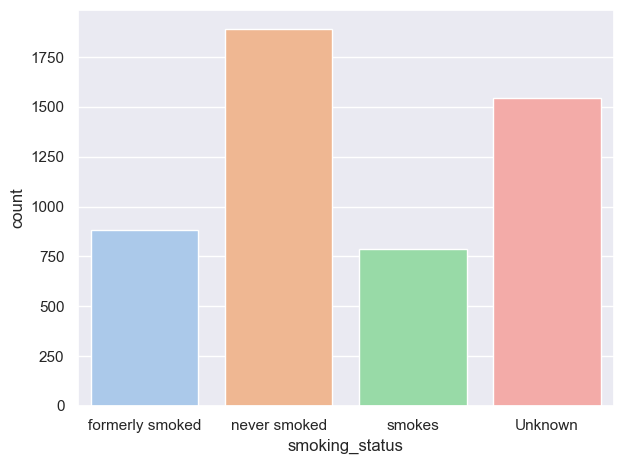

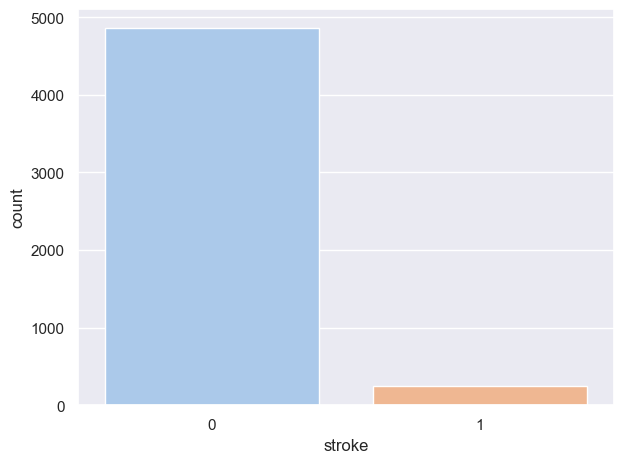

In [66]:
categorical_cols = ['gender', 'heart_disease', 'hypertension', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
sns.set_theme(style='darkgrid')
sns.set_palette('pastel')
for feature in categorical_cols:
    sns.countplot(data=data, x=feature)
    plt.tight_layout()
    plt.show()

This dataset is imbalanced, thus additional preprocessing steps must be taken to achieve better results on the model

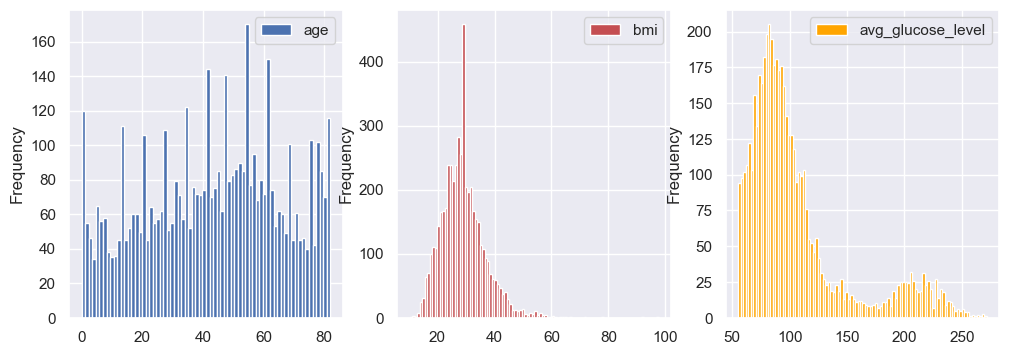

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

data.plot(kind="hist", y="age", bins=70, color="b", ax=axes[0])
data.plot(kind="hist", y="bmi", bins=100, color="r", ax=axes[1])
data.plot(kind="hist", y="avg_glucose_level", bins=100, color="orange", ax=axes[2])

plt.show()

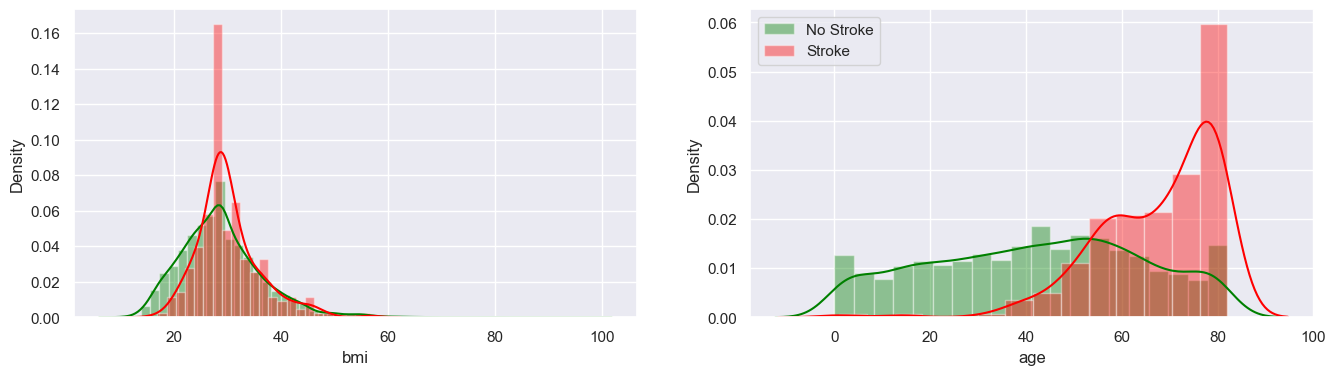

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(data[data['stroke'] == 0]["bmi"], color='green', label='No Stroke', ax=axes[0])
sns.distplot(data[data['stroke'] == 1]["bmi"], color='red', label='Stroke', ax=axes[0])
sns.distplot(data[data['stroke'] == 0]["age"], color='green', label='No Stroke', ax=axes[1])
sns.distplot(data[data['stroke'] == 1]["age"], color='red', label='Stroke', ax=axes[1])
plt.legend()
plt.show()

## Data Preprocessing

In [69]:
# Label encoding, standard scaler, SMOTE overfitting on train data only
# For models, try logistic regression, xgboost
# Standardizing
scaler = StandardScaler()

scale_cols = ['age', 'avg_glucose_level', 'bmi']

data[scale_cols] = scaler.fit_transform(data[scale_cols])
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.050950,0,1,Yes,Private,Urban,2.706375,1.001234e+00,formerly smoked,1
1,Female,0.785835,0,0,Yes,Self-employed,Rural,2.121559,4.615554e-16,never smoked,1
2,Male,1.625367,0,1,Yes,Private,Rural,-0.005028,4.685773e-01,never smoked,1
3,Female,0.255604,0,0,Yes,Private,Urban,1.437358,7.154182e-01,smokes,1
4,Female,1.581181,1,0,Yes,Self-employed,Rural,1.501184,-6.357112e-01,never smoked,1


In [74]:
non_numeric_columns = data.select_dtypes(exclude=['number']).columns.tolist()
for col in non_numeric_columns:
    data[col] = data[col].str.lower()

In [75]:
data.columns = data.columns.str.lower()

In [88]:
from sklearn.preprocessing import OneHotEncoder
categorical_cols =['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
data_encoded = pd.concat([data, encoded_df], axis=1)
data_encoded.drop(categorical_cols, axis=1, inplace=True)
data_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_female,gender_male,gender_other,ever_married_no,...,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self-employed,residence_type_rural,residence_type_urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_unknown
0,1.050950,0,1,2.706375,1.001234e+00,1,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.785835,0,0,2.121559,4.615554e-16,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.625367,0,1,-0.005028,4.685773e-01,1,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.255604,0,0,1.437358,7.154182e-01,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.581181,1,0,1.501184,-6.357112e-01,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [89]:
data_encoded.shape

(5110, 22)

In [90]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_female                   5110 non-null   float64
 7   gender_male                     5110 non-null   float64
 8   gender_other                    5110 non-null   float64
 9   ever_married_no                 5110 non-null   float64
 10  ever_married_yes                5110 non-null   float64
 11  work_type_children              5110 non-null   float64
 12  work_type_govt_job              51

In [91]:
data_encoded.to_csv('data/processed/processed.csv')

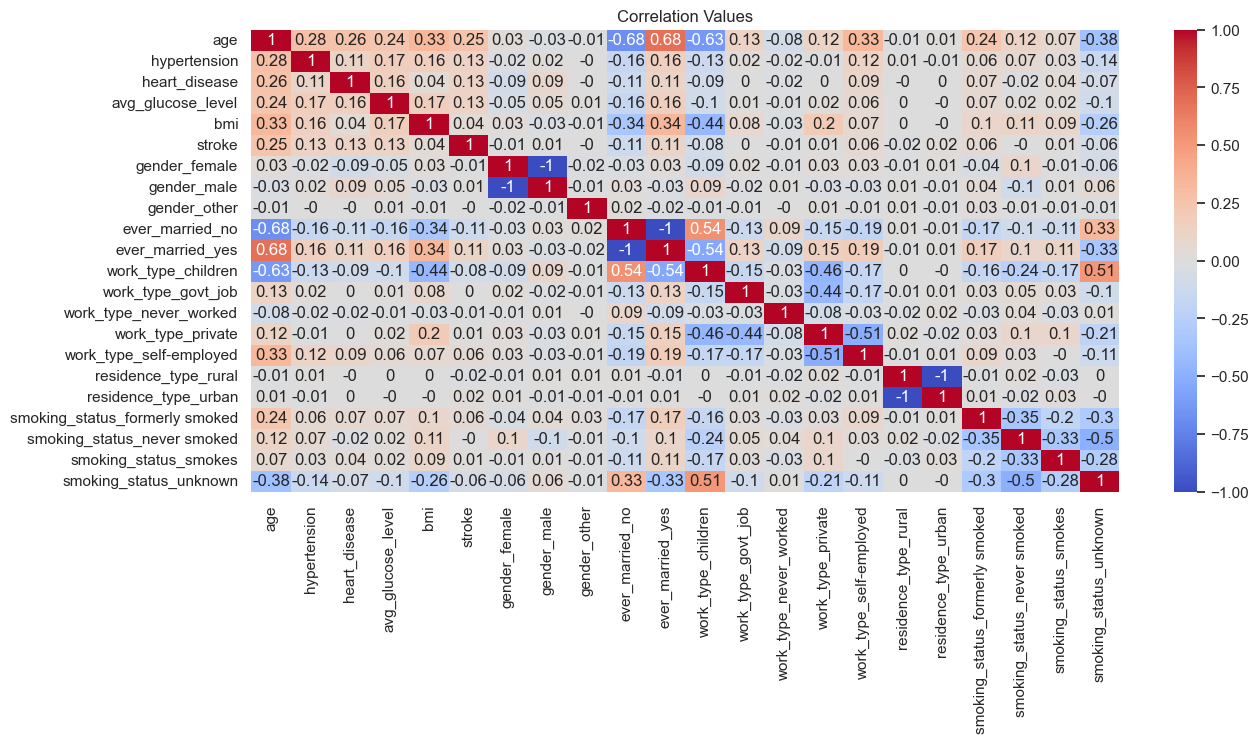

In [92]:
# Correlation Matrix to Identify Relationships After Preprocessing
plt.figure(figsize=(14,6))
sns.heatmap(data_encoded.corr(numeric_only=True).round(2), annot=True, cmap='coolwarm')
plt.title('Correlation Values')
plt.show()

# Predictive Modelling
### Splitting Data

Seeing as the dataset is imbalanced, I will use imblearn's SMOTE to prevent overfitting and make a balanced training dataset

In [221]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']

# Fit and resample minority class
X_bal, y_bal = smote.fit_resample(X, y)

(9722, 21)

In [223]:

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

print("Finished training and testing split.")

Finished training and testing split.


In [224]:
print('x_train: ', X_train.shape)
print('x_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (6805, 21)
x_test:  (2917, 21)
y_train:  (6805,)
y_test:  (2917,)


In [225]:
y_train.value_counts()

stroke
0    3404
1    3401
Name: count, dtype: int64

In [226]:
y_test.value_counts()

stroke
1    1460
0    1457
Name: count, dtype: int64

In [157]:
y_train.value_counts()

stroke
0    3403
1     174
Name: count, dtype: int64

In [227]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train, y_train)
LR_train_score = LR.score(X_train, y_train)
LR_test_score = LR.score(X_test, y_test)

y_pred = LR.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Training Score', LR_train_score)
print('Testing Score ', LR_test_score)
print(cm)

Training Score 0.7876561351947098
Testing Score  0.7908810421666095
[[1081  376]
 [ 234 1226]]


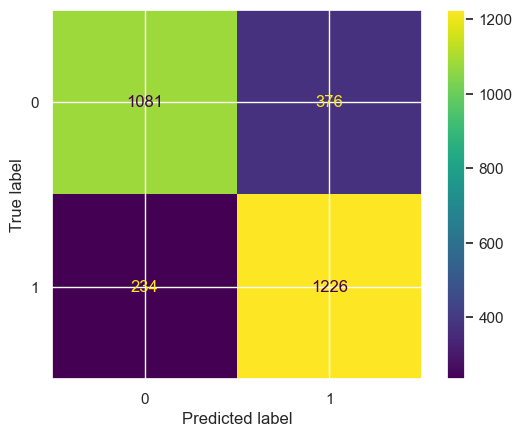

In [228]:
ConfusionMatrixDisplay(cm).plot()

In [307]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9609187521426122


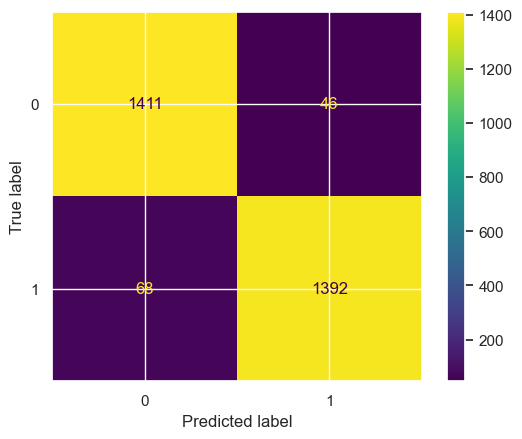

In [308]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

LR Hyperparameter Tuning Using Optuna

In [261]:
import optuna
from sklearn.metrics import f1_score

# Create the objective function
def objective(trial):
    X_tra, X_valid, y_tra, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    model = LogisticRegression(C=C, random_state=42)
    model.fit(X_tra, y_tra)
    y_pred = model.predict(X_valid)
    score = f1_score(y_valid, y_pred)

    return score


In [262]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params

[I 2023-09-20 17:03:11,036] A new study created in memory with name: no-name-34c763fa-9e65-4056-b190-c4cd2422ee2e
[I 2023-09-20 17:03:11,054] Trial 0 finished with value: 0.7774798927613941 and parameters: {'C': 2.483421852550401e-05}. Best is trial 0 with value: 0.7774798927613941.
[I 2023-09-20 17:03:11,104] Trial 1 finished with value: 0.7937853107344632 and parameters: {'C': 1.336657264293294}. Best is trial 1 with value: 0.7937853107344632.
[I 2023-09-20 17:03:11,122] Trial 2 finished with value: 0.7757009345794393 and parameters: {'C': 2.284891070725921e-05}. Best is trial 1 with value: 0.7937853107344632.
[I 2023-09-20 17:03:11,141] Trial 3 finished with value: 0.7729658792650919 and parameters: {'C': 1.606928878508382e-05}. Best is trial 1 with value: 0.7937853107344632.
[I 2023-09-20 17:03:11,156] Trial 4 finished with value: 0.7875862068965517 and parameters: {'C': 0.0009237082860920785}. Best is trial 1 with value: 0.7937853107344632.
[I 2023-09-20 17:03:11,183] Trial 5 fini

In [327]:
model = LogisticRegression(**best_params)

Model Performance Metrics

In [328]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7895097703119643


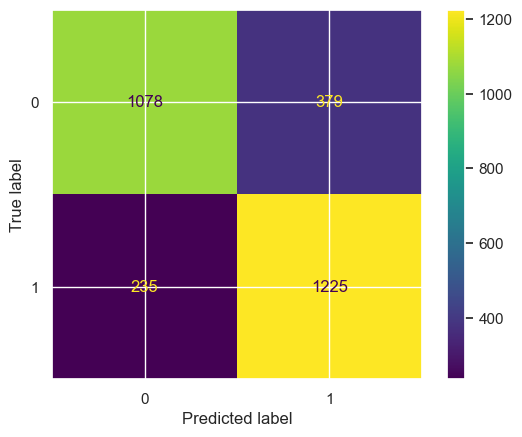

In [329]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Although the model seems to be somewhat accurate, in the context of stroke detection, it is essential for false negatives to be mitigated, as severe consequences can occur from classifying a patient as not prone to having a stroke when they truly are. Thus, it is feasible to mitigate false negatives at the cost of the model's accuracy.

In [330]:
# Change the classification threshold
model.fit(X_train, y_train)
predicted_probabilities = model.predict_proba(X_test)[:, 1]

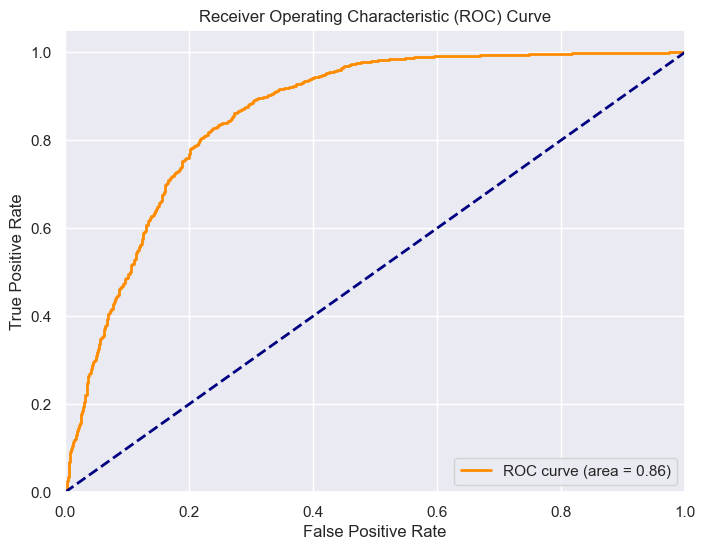

In [331]:
# Analyze ROC curve to determine the right threshold
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, predicted_probabilities))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [334]:
custom_threshold = 0.45
binary_predictions = (predicted_probabilities >= custom_threshold).astype(int)
print(accuracy_score(y_test, binary_predictions))

0.7922523140212547


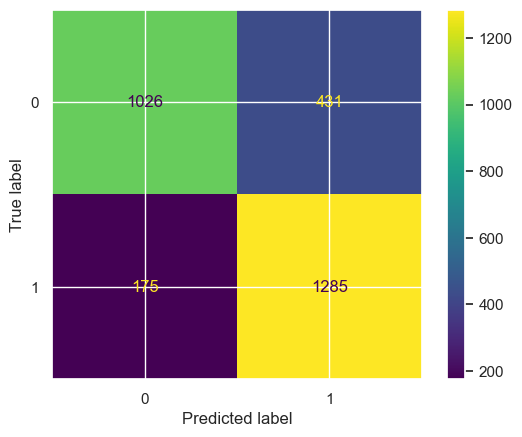

In [335]:
cm = confusion_matrix(y_test, binary_predictions)
ConfusionMatrixDisplay(cm).plot()

While our false positive rate has increased, the false negative rate has decreased coupled with an increased number of true positives.

In [337]:
# Exporting finished model
import joblib
joblib.dump(model, 'models/lrmodel.pkl')

['models/lrmodel.pkl']

Pipeline creation

In [338]:
Xd = data.drop('stroke', axis=1)
yd = data['stroke']
X_trd, X_td, y_trd, y_td = train_test_split(Xd, yd, test_size=0.3, stratify=y, random_state=42)

In [339]:
data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [340]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_cols),
        ('cat', OneHotEncoder(sparse=False, drop='first'), categorical_cols)
    ])

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('xgboost', model)
])

pipe.fit(X_td, y_td)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'residence_type',
                                                   'smoking_status'])])),
                ('xgboost', LogisticRegression(C=0.2920518807617348))])

In [342]:
example = pd.DataFrame({
    "age": [105.0],
    "hypertension": [1],
    "heart_disease": [1],
    "avg_glucose_level": [100.0],
    "bmi": [1008.5],
    "gender": ["male"],
    "ever_married": ["yes"],
    "work_type": ["govt_job"],
    "residence_type": ["urban"],
    "smoking_status": ["smokes"]
})

pipe.predict(example).sum()

1

In [343]:
joblib.dump(pipe, "app/pipelines/lr_pipeline.pkl")

['app/pipelines/lr_pipeline.pkl']